# Game Type Classification and AI Detection Analysis

This notebook classifies game sessions and analyzes questionnaire responses:
- Classifies sessions into: Human–Human, Human–GPT, Mixed, or Unknown based on `partnerAgentType`
- Analyzes questionnaire data including AI detection, collaboration rating, and play again intention


In [105]:
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# Configuration
DATA_DIR = Path.cwd().parent / 'data'
FALLBACK = Path('../multiplePlayerGridGame_socketIO/data')
if (DATA_DIR / 'data').is_dir():
    DATA_DIR = DATA_DIR / 'data'
elif FALLBACK.is_dir():
    DATA_DIR = FALLBACK.resolve()
print('Using data dir:', DATA_DIR)

EXCEL_GLOB = 'experiment_data_*.xlsx'
EXPERIMENT_COL = 'experimentType'
PARTNER_COL = 'partnerAgentType'
TARGET_EXPERIMENTS = {'2P2G','2P3G'}

# Plotting setup
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

game_type_colors = {
    'human-human': 'lightblue',
    'human-gpt': 'lightcoral',
    'mixed': 'lightgreen'
}

def extract_room_id_from_filename(path: Path):
    m = re.search(r'_room_([0-9a-fA-F-]+)_', path.name)
    return m.group(1) if m else None

def pick_experiment_sheet(book: dict):
    for name, df in book.items():
        cols = set(map(str, df.columns))
        if EXPERIMENT_COL in cols or PARTNER_COL in cols:
            return name
    return list(book.keys())[0] if book else None

def pick_questionnaire_sheet(book: dict):
    for name, df in book.items():
        cols = set(map(str, df.columns))
        if 'ai_detection' in cols:
            return name
    for name in book.keys():
        if 'question' in name.lower():
            return name
    return None


Using data dir: /Users/chengshaozhe/Documents/DukeECClab/code/multiplePlayerGridGame_socketIO/data


In [106]:
# Load data files
excel_paths = sorted(DATA_DIR.glob(EXCEL_GLOB))
print(f'Found {len(excel_paths)} files')


Found 51 files


In [107]:
# Classify game sessions by partner agent type
records = []
questionnaire_rows = []

for p in excel_paths:
    try:
        book = pd.read_excel(p, sheet_name=None)
    except Exception as e:
        print('Read error for', p.name, '->', e)
        continue
    if not book:
        continue

    exp_sheet = pick_experiment_sheet(book)
    exp_df = book.get(exp_sheet, pd.DataFrame()).copy()
    room_id = extract_room_id_from_filename(p)

    # Collect partner types from target experiments
    partner_types = set()
    exp_types_present = set()
    if not exp_df.empty and EXPERIMENT_COL in exp_df.columns and PARTNER_COL in exp_df.columns:
        subset = exp_df[exp_df[EXPERIMENT_COL].isin(TARGET_EXPERIMENTS)]
        exp_types_present = set(subset[EXPERIMENT_COL].dropna().astype(str).unique())
        partner_types = set(subset[PARTNER_COL].dropna().astype(str).str.strip().str.lower().unique())

    # Classify game sessions
    if len(partner_types) == 0:
        game_class = 'unknown'
    elif partner_types == {'human'}:
        game_class = 'human-human'
    elif all(pt != 'human' for pt in partner_types):
        game_class = 'human-gpt'  # Renamed from 'human-ai'
    else:
        game_class = 'mixed'

    records.append({
        'file_id': p.name,
        'room_id': room_id,
        'exp_types_present': ','.join(sorted(exp_types_present)) if exp_types_present else '',
        'partner_types': ','.join(sorted(partner_types)) if partner_types else '',
        'game_class': game_class
    })

    # Collect questionnaire data
    q_sheet = pick_questionnaire_sheet(book)
    if q_sheet:
        qdf = book[q_sheet].copy()
        if not qdf.empty:
            qdf['file_id'] = p.name
            qdf['room_id'] = room_id
            questionnaire_rows.append(qdf)

class_df = pd.DataFrame.from_records(records)
print('Classified files:', len(class_df))


Classified files: 51


In [108]:
# Game classification summary
summary_counts = class_df['game_class'].value_counts(dropna=False)
print("Game Classification Summary:")
for game_type, count in summary_counts.items():
    print(f"  {game_type}: {count}")
print(f"\nTotal files: {len(class_df)}")


Game Classification Summary:
  human-human: 28
  human-gpt: 12
  mixed: 11

Total files: 51


In [109]:
# Mixed game sessions analysis
mixed_files = class_df[class_df['game_class'] == 'mixed']

if len(mixed_files) > 0:
    print(f"Mixed game sessions: {len(mixed_files)}")
    mixed_percentages = []

    for _, row in mixed_files.iterrows():
        file_id = row['file_id']
        file_path = next((p for p in excel_paths if p.name == file_id), None)

        if file_path:
            try:
                book = pd.read_excel(file_path, sheet_name=None)
                exp_sheet = pick_experiment_sheet(book)
                exp_df = book[exp_sheet].copy()

                if not exp_df.empty and EXPERIMENT_COL in exp_df.columns and PARTNER_COL in exp_df.columns:
                    subset = exp_df[exp_df[EXPERIMENT_COL].isin(TARGET_EXPERIMENTS)].copy()
                    if not subset.empty:
                        partner_types = subset[PARTNER_COL].dropna().astype(str).str.strip().str.lower()
                        total_trials = len(partner_types)
                        human_trials = len(partner_types[partner_types == 'human'])
                        human_percentage = (human_trials / total_trials * 100) if total_trials > 0 else 0
                        mixed_percentages.append(human_percentage)
            except Exception as e:
                print(f"Error processing {file_id}: {e}")

    if mixed_percentages:
        print(f"Human partner percentages in mixed sessions: {mixed_percentages}")
else:
    print("No mixed game sessions found.")


Mixed game sessions: 11
Human partner percentages in mixed sessions: [30.0, 94.73684210526315, 35.0, 40.0, 80.0, 95.0, 95.0, 95.0, 40.0, 30.0, 35.0]


## Questionnaire Analysis by Game Type

Analysis of questionnaire responses by game classification:
- **AI Detection**: AI-like to Human-like responses
- **Collaboration Rating**: Poor to Excellent ratings  
- **Play Again Intention**: Negative to Positive intentions

Comparing Human-Human vs Human-GPT game types.


In [110]:
# Define ordinal mappings for questionnaire responses (matching TimelineManager.js order)
ai_detection_order = [
    'Definitely a person',
    'Probably a person',
    'Not sure',
    'Probably an AI',
    'Definitely an AI'
]

collaboration_order = [
    'Very poor collaborator',
    'Poor collaborator',
    'Neutral',
    'Good collaborator',
    'Very good collaborator'
]

play_again_order = [
    'Definitely not play again',
    'Probably not play again',
    'Not sure',
    'Probably play again',
    'Definitely play again'
]

print("Questionnaire response orderings defined (matching experiment settings)")


Questionnaire response orderings defined (matching experiment settings)


In [111]:
# Prepare questionnaire data for analysis
if questionnaire_rows:
    quest_df = pd.concat(questionnaire_rows, ignore_index=True)
    quest_with_class = quest_df.merge(class_df[['file_id', 'game_class']], on='file_id', how='left')

    # Focus on human-human and human-gpt for main analysis
    main_analysis_data = quest_with_class[quest_with_class['game_class'].isin(['human-human', 'human-gpt'])].copy()

    print(f"Total questionnaire responses: {len(quest_df)}")
    print(f"Main analysis data (human-human + human-gpt): {len(main_analysis_data)}")
    print(f"Game class distribution: {quest_with_class['game_class'].value_counts().to_dict()}")

    # Check available measures
    has_ai_detection = 'ai_detection' in quest_df.columns
    has_collaboration = 'collaboration_rating' in quest_df.columns
    has_play_again = 'play_again' in quest_df.columns

    print(f"\nAvailable measures: AI Detection: {has_ai_detection}, Collaboration: {has_collaboration}, Play Again: {has_play_again}")
else:
    print("No questionnaire data found!")
    quest_with_class = pd.DataFrame()
    main_analysis_data = pd.DataFrame()


Total questionnaire responses: 51
Main analysis data (human-human + human-gpt): 40
Game class distribution: {'human-human': 28, 'human-gpt': 12, 'mixed': 11}

Available measures: AI Detection: True, Collaboration: True, Play Again: True


In [112]:
# Create categorical variables for analysis
if not main_analysis_data.empty:
    if has_ai_detection:
        main_analysis_data['ai_detection_cat'] = pd.Categorical(
            main_analysis_data['ai_detection'], categories=ai_detection_order, ordered=True)

    if has_collaboration:
        main_analysis_data['collaboration_rating_cat'] = pd.Categorical(
            main_analysis_data['collaboration_rating'], categories=collaboration_order, ordered=True)

    if has_play_again:
        main_analysis_data['play_again_cat'] = pd.Categorical(
            main_analysis_data['play_again'], categories=play_again_order, ordered=True)

    print(f"Analysis data ready: {main_analysis_data.shape}")
    print(f"Game classes: {main_analysis_data['game_class'].value_counts().to_dict()}")
else:
    print("No data available for analysis")


Analysis data ready: (40, 14)
Game classes: {'human-human': 28, 'human-gpt': 12}


=== AI DETECTION ANALYSIS ===


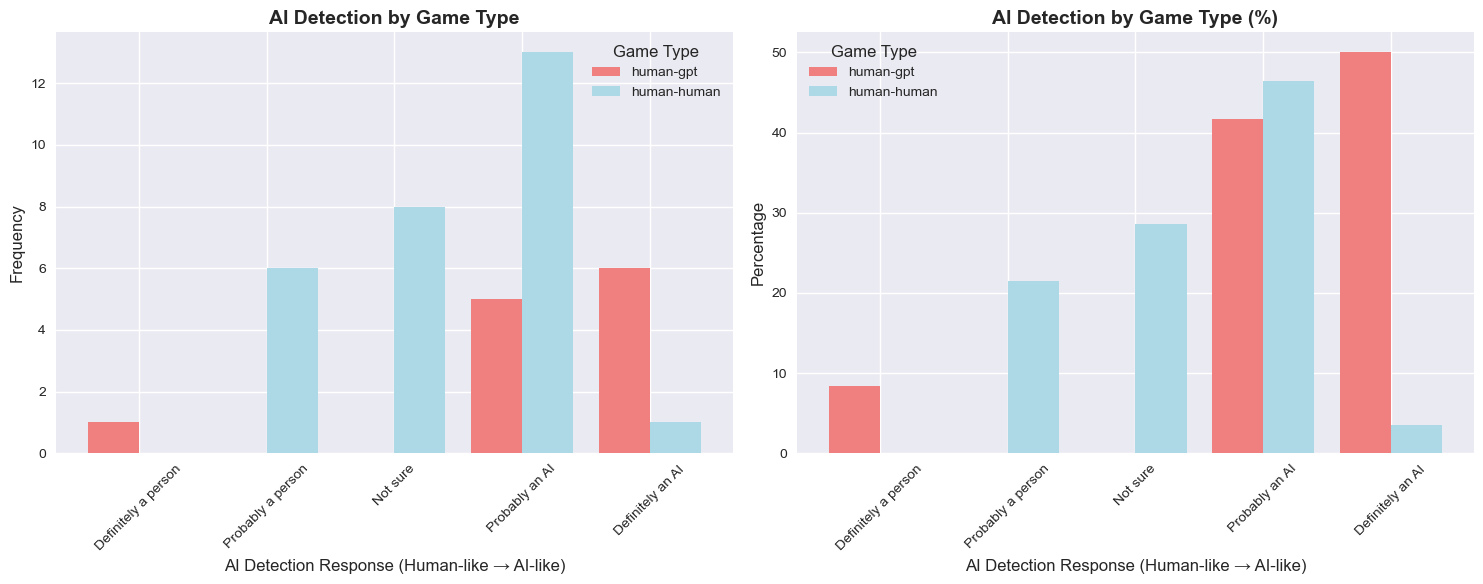


Chi-square test: χ² = 18.723, p = 0.001
Human Human: 14/28 (50.0%) detected as AI-like
Human Gpt: 11/12 (91.7%) detected as AI-like


In [113]:
# AI Detection Analysis
if not main_analysis_data.empty and has_ai_detection:
    print("=== AI DETECTION ANALYSIS ===")

    # Prepare data
    ai_data = main_analysis_data.groupby(['game_class', 'ai_detection_cat'], observed=True).size().unstack(fill_value=0)

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Frequency plot
    plot_colors = [game_type_colors[game_type] for game_type in ai_data.index]
    ai_data.T.plot(kind='bar', ax=ax1, width=0.8, color=plot_colors)
    ax1.set_title('AI Detection by Game Type', fontsize=14, fontweight='bold')
    ax1.set_xlabel('AI Detection Response (Human-like → AI-like)', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.legend(title='Game Type')
    ax1.tick_params(axis='x', rotation=45)

    # Percentage plot
    ai_data_norm = ai_data.div(ai_data.sum(axis=1), axis=0) * 100
    ai_data_norm.T.plot(kind='bar', ax=ax2, width=0.8, color=plot_colors)
    ax2.set_title('AI Detection by Game Type (%)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('AI Detection Response (Human-like → AI-like)', fontsize=12)
    ax2.set_ylabel('Percentage', fontsize=12)
    ax2.legend(title='Game Type')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Statistical test
    contingency_ai = pd.crosstab(main_analysis_data['game_class'], main_analysis_data['ai_detection'])
    chi2_ai, p_value_ai, _, _ = chi2_contingency(contingency_ai)
    print(f"\nChi-square test: χ² = {chi2_ai:.3f}, p = {p_value_ai:.3f}")

    # Summary statistics
    for game_type in ['human-human', 'human-gpt']:
        if game_type in main_analysis_data['game_class'].values:
            subset = main_analysis_data[main_analysis_data['game_class'] == game_type]
            ai_like_count = len(subset[subset['ai_detection'].isin(['Definitely an AI', 'Probably an AI'])])
            total = len(subset)
            print(f"{game_type.replace('-', ' ').title()}: {ai_like_count}/{total} ({100*ai_like_count/total:.1f}%) detected as AI-like")
else:
    print("Cannot perform AI detection analysis")


=== COLLABORATION RATING ANALYSIS ===


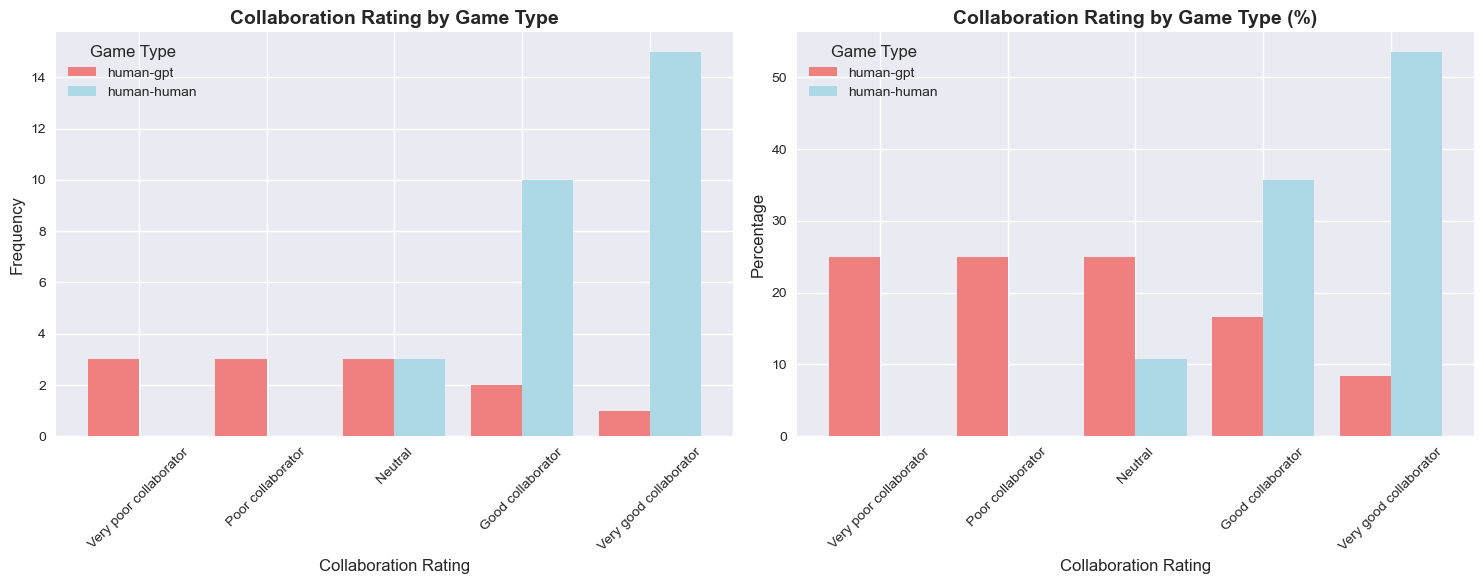


Chi-square test: χ² = 20.456, p = 0.000
Human Human: 25/28 (89.3%) rated as good collaborators
Human Gpt: 3/12 (25.0%) rated as good collaborators


In [114]:
# Collaboration Rating Analysis
if not main_analysis_data.empty and has_collaboration:
    print("=== COLLABORATION RATING ANALYSIS ===")

    # Prepare data
    collab_data = main_analysis_data.groupby(['game_class', 'collaboration_rating_cat'], observed=True).size().unstack(fill_value=0)

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Frequency plot
    plot_colors = [game_type_colors[game_type] for game_type in collab_data.index]
    collab_data.T.plot(kind='bar', ax=ax1, width=0.8, color=plot_colors)
    ax1.set_title('Collaboration Rating by Game Type', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Collaboration Rating', fontsize=12)
    ax1.set_ylabel('Frequency', fontsize=12)
    ax1.legend(title='Game Type')
    ax1.tick_params(axis='x', rotation=45)

    # Percentage plot
    collab_data_norm = collab_data.div(collab_data.sum(axis=1), axis=0) * 100
    collab_data_norm.T.plot(kind='bar', ax=ax2, width=0.8, color=plot_colors)
    ax2.set_title('Collaboration Rating by Game Type (%)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Collaboration Rating', fontsize=12)
    ax2.set_ylabel('Percentage', fontsize=12)
    ax2.legend(title='Game Type')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Statistical test
    contingency_collab = pd.crosstab(main_analysis_data['game_class'], main_analysis_data['collaboration_rating'])
    chi2_collab, p_value_collab, _, _ = chi2_contingency(contingency_collab)
    print(f"\nChi-square test: χ² = {chi2_collab:.3f}, p = {p_value_collab:.3f}")

    # Summary statistics
    for game_type in ['human-human', 'human-gpt']:
        if game_type in main_analysis_data['game_class'].values:
            subset = main_analysis_data[main_analysis_data['game_class'] == game_type]
            good_collab_count = len(subset[subset['collaboration_rating'].isin(['Very good collaborator', 'Good collaborator'])])
            total = len(subset)
            print(f"{game_type.replace('-', ' ').title()}: {good_collab_count}/{total} ({100*good_collab_count/total:.1f}%) rated as good collaborators")
else:
    print("Cannot perform collaboration rating analysis")
